In [ ]:
import zipfile
zipf=zipfile.ZipFile('Named_Entity_Recognition.zip',"r")
zipf.extractall()
zipf.close()

In [ ]:
import zipfile
zipf2=zipfile.ZipFile('ner_dataset.csv.zip',"r")
zipf2.extractall()
zipf2.close()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
np.random.seed(0)

In [4]:
df=pd.read_csv('ner_dataset.csv',encoding='latin1')
#fill missing data with last valid value
df=df.fillna(method='ffill')
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [5]:
df.head(25)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
print('unique words in corupus',df['Word'].nunique())
print('unique tags in corupus',df['Tag'].nunique())

unique words in corupus 35178
unique tags in corupus 17


In [7]:
print(df['Tag'].unique())

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [8]:
#add padding token to end of each of vocab and tags
words=list(set(df['Word'].values))
words.append('ENDVOC')
num_words=len(words)

In [9]:
num_words

35179

In [10]:
print(words[:10])

['RONCO', 'al-Hakim', 'teeth', 'Ono', 'concludes', 'mid-2007', '1802', 'pen', '1.55', 'Major-General']


In [11]:
#add padding token to end of each of vocab and tags
tags=list(set(df['Tag'].values))
num_tags=len(tags)

In [12]:
num_tags

17

In [13]:
#retrieve sentences and corresponding tags
class get_sentence(object):
  def __init__(self,data):
    self.n_sentence=1
    self.data=data
    #group into 3 tuplevalues
    agg_func=lambda s:[(w,p,t) for w,p,t in zip(s['Word'].values.tolist(),s['POS'].values.tolist(),s['Tag'].values.tolist())]

    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    self.sentences=[s for s in self.grouped]

In [14]:
sentence_getter=get_sentence(df)
sentences=sentence_getter.sentences

In [15]:
sentences[0]#read the sentences top to down

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [16]:
#define mappings between sentences and tags
words_to_index={word:i+1 for i,word in enumerate(words)}
tags_to_index={tag:i for i,tag in enumerate(tags)}

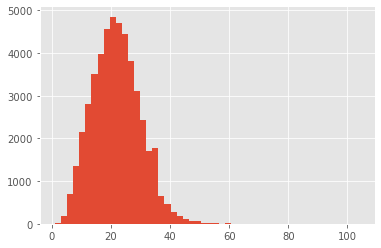

In [17]:
#see the distribution of sentence lengths for better idea
plt.hist([len(s) for s in sentences],bins=50)
plt.show()

In [18]:
import tensorflow as tf

In [19]:
#since most of the sentences are of length 20-22 so we can choose a safe length of 50
max_length=50

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
x=[ [words_to_index[w[0] ]  for w in s ]for s in sentences]
x=pad_sequences(maxlen=max_length,sequences=x,padding='post',value=num_words-1)

y=[ [tags_to_index[word[2]] for word in sentence ]for sentence in sentences ]
y=pad_sequences(maxlen=max_length,sequences=y,padding='post',value=tags_to_index['O'])
y=[to_categorical(i,num_classes=num_tags)for i in y]

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=1)

In [22]:
#build and compile NER MODEL
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense,TimeDistributed,SpatialDropout1D,Bidirectional

In [23]:
input_word=Input(shape=(max_length,))
model=Embedding(input_dim=num_words,output_dim=max_length,input_length=max_length)(input_word)
#spatialdropout instead of dropping nodes,drops randomly a feature dimension across the feature map
model=SpatialDropout1D(0.1)(model)
#bidirectional learns from past,present and future sequence..is better and context aware
model=Bidirectional(LSTM(recurrent_activation='sigmoid',units=100,return_sequences=True,recurrent_dropout=0,unroll=False,use_bias=True))(model)
#timedistributed accepts a layer as input and applies the dense layer to every time slice of the input
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
from keras.callbacks import ModelCheckpoint
# from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [26]:
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
# callbacks=[PlotLossesCallback(),early_stopping]
history=model.fit(x_train,np.array(y_train),
                  validation_split=0.2,
                  batch_size=32,
                  epochs=10,
                  verbose=1,
                  )

Epoch 1/10


UnknownError:    [_Derived_]Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model/bidirectional/forward_lstm/StatefulPartitionedCall]]
	 [[gradient_tape/model/embedding/embedding_lookup/Reshape/_38]] [Op:__inference_train_function_5956]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
model.evaluate(x_test,np.array(y_test))

4796/4796 [==============================] - 2s 508us/step


[0.04990915436487182, 0.9856797456741333]

In [ ]:
#words,true,predict
indices=np.random.randint(0,x_test.shape[0])
predictions=model.predict(np.array([x_test[indices]]))
predictions=np.argmax(predictions,axis=-1)

actual=np.argmax(np.array(y_test),axis=-1)[indices]

In [ ]:
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[indices], actual, predictions[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
Court          B-org	B-org
of             I-org	I-org
Arbitration    I-org	I-org
for            I-org	I-org
Sport          I-org	I-org
has            O	O
upheld         O	O
the            O	O
two-year       B-tim	O
doping         O	O
ban            O	O
given          O	O
to             O	O
German         B-gpe	B-gpe
cyclist        O	O
Danilo         B-per	B-per
Hondo          I-per	I-per
,              O	O
after          O	O
he             O	O
twice          O	O
tested         O	O
positive       O	O
for            O	O
a              O	O
stimulant      O	O
(              O	O
carphedon      O	O
)              O	O
at             O	O
the            B-geo	O
Tour           I-geo	O
of             I-geo	I-org
Murcia         I-geo	I-org
in             O	O
Spain          B-geo	B-geo
last           O	O
March          B-tim	B-tim
.              O	O
Lisjak         O	O
Lisjak         O	O
Lisjak         O	O
Lisjak         O